In [1]:
# Needed imports
import re
import time
import requests
import os
import pandas as pd
import html5lib
from bs4 import BeautifulSoup
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import disp_functions as df
plt.rcParams["figure.dpi"] = 300

In [42]:
# Ceiling function
def ceil(n) :
    '''
    Calculates the ceiling of a number.
    
    Input :
        n (float) - A real number for which you want to find the ceiling value.
        
    Outpu :
        n rounded up.
    '''
    if int(n) == n :
        return n
    else :
        return int(n)+1

# Returns a number mod 40, but returns 40 instead of 0
# This is because of how the xpath for the tables on the homepage of kenpom.com is determined.
def mod_fix(n,r=40) :
    '''
    Calculates modular arithmitic, but replaces 0 with n.
    
    Input :
        n (int) - The dividend of the modular arithmitic.
        r (int) - The divisor of the modular arithmitic.
        
    Returns :
        n % r , but n instead of 0
    '''
    if n%r == 0 :
        return r
    else :
        return n%r

# Path to data
path = "./DATA/"

# Homepage for kenpom.com
home_url = "https://kenpom.com/"

def login(browser) :
    '''
    Opens kenpom.com in a chrome browser and prompts user for login information.
    Once it logs in, the function exits, leaving the browser open.
    
    Inputs :
        browser - A web browser handle controlled by python.
    '''
    # Go to webpage
    try :
        browser.get(home_url)
        # Enter user id
        try :
            # Get the email element
            usr = browser.find_element_by_name('email')
            # Empty it of contents
            usr.clear()
            # Prompt user for email
            email = str(input("EMAIL: "))
            # Type email into element
            usr.send_keys(email)
        except :
            # Should a problem occur, don't do anything
            print("Couldn't find email.")
            # Raise an error to stop the function
            raise ValueError("Field not found.")
        # Enter password
        try :
            # Get the password element
            pwd = browser.find_element_by_name('password')
            # Clear it of current contents
            pwd.clear()
            # Prompt user for password
            psswd = str(input("PASSWORD: "))
            # Type password into element
            pwd.send_keys(psswd)
        except :
            # Should a problem occur, don't do anything
            print("Couldn't find password bar.")
            # Raise an error to stop the function
            raise ValueError("Field not found.")
        # Click login button
        try :
            # Find the button
            login = browser.find_element_by_name('submit')
            # Click it
            login.click()
        except :
            # If you couldn't for some reason, do nothing
            print("Couldn't find login button.")
            # Raise an error to stop the function
            raise ValueError("Button not found.")
        # Switch to new page
        browser.switch_to_window(browser.window_handles[-1])
    except :
        # If the website doesn't exist for some reason, do nothing
        print("Couldn't find home page.")
        # Raise an error to stop the function
        raise ValueError("Page not found.")
    return browser

def get_scouting_report(browser,team_path) :
    '''
    Get the scouting report for a specific team from kenpom.com
    
    Inputs :
        browser - The browser we're controlling
        team_path (str) - The directory path to the folder where we're saving the info.
    '''
    # Get scouting report table
    # Turn the page into soup
    team_soup = BeautifulSoup(browser.page_source, 'html.parser')
    # Find the scouting report
    report = team_soup.find('div', attrs={'id':'report'})
    # Open an html file
    with open(team_path+'Scouting_Report','w') as outfile :
        # Save table to file
        outfile.write(str(report))

def get_players(browser,current_team,team_path,year) :
    '''
    Gets data for the players of a specific team in a specific year
    
    Inputs :
        browser - The browser we're controlling
        current_team (handle) - The handle for the team page
                                This is the page we want to return to when we're done.
        team_path (str) - Path to where we're saving this team's data
        year (str) - The current year we're scraping
    '''
    # The numbers in this range include all players, but some are missing different values.
    # This will skip the missing ones and grab the ones that do exist.
    for i in range(20) :
        try :
            # Player link by xpath
            player = browser.find_element_by_xpath('//*[@id="player-table"]/tbody/tr[{}]/td[2]/a[1]'.format(i))
            # Get the name of the player for the file name
            #player_name = player.text
            # Open link in new tab
            player.send_keys(Keys.COMMAND + Keys.RETURN)
            # Wait for tab to load
            time.sleep(2)
            # Switch view to new tab
            browser.find_element_by_tag_name('body').send_keys(Keys.CONTROL + Keys.TAB)
            # Switch browser to new tab
            browser.switch_to_window(browser.window_handles[-1])
            # Get player table and save to player file
            player_soup = BeautifulSoup(browser.page_source, 'html.parser')
            # Gets player name
            player_name = player_soup.find_all('div',attrs={'id' : 'content-header'})[0].find_all('span',attrs={'class' : 'name'})[0].get_text()
            # Creates the part of the path for where the player's data will be saved
            #player_path = team_path + player_name
            # Get schedule data
            table = player_soup.find_all('table', attrs={'id':'schedule-table'})
            # Check all tables if they're the ones we want
            for i in range(len(table)) :
                # This element appears above the table pertaining to the desired year's schedule
                if browser.find_element_by_xpath('//*[@id="players"]/h3[{}]'.format(i+1)).text == year + " Game Data" :
                    # Create the file as path_to_team_folder/team_name/player_name #
                    # The reson for the # at the end is to verify later that the correct table
                    #     was saved.
                    with open(team_path+player_name+' {}'.format(i),'w') as outfile :
                        # Write the file
                        outfile.write(str(table[i]))
            # Close the player tab
            browser.close()
            # Switch to team tab
            browser.switch_to_window(current_team)
        # If the xpath was for an invalid player (some of them will be) do nothing
        except NoSuchElementException :
            pass
        

def get_years(years) :
    '''
    Goes through kenpom.com year by year for the years provided to scrape data
    
    Inputs :
        years (list) - List of years we want to scrape (strings)
    '''
    # For each year of interest
    for year in years :
        # Don't want to overload the server
        time.sleep(1)
        # Get the link for given year
        try :
            # Save page, because we'll be returning to it a lot
            current_year = browser.current_window_handle
            # Create folder for year if not already in existence
            if not os.path.exists(path+year+'/') :
                os.makedirs(path+year+'/')
            # Initialize list of teams
            teams = []
            # Counter for specific xpath
            i = 1
            # 68 teams (round of 64 and first 4 gives 4 additional)
            while len(teams) < 68 and i < 350:
                # Can't hurt to treat the server gently
                time.sleep(1)
                try :
                    # Team link by xpath
                    team = browser.find_element_by_xpath('//*[@id="ratings-table"]/tbody[{}]/tr[{}]/td[2]/a'.format(ceil(i/40),mod_fix(i)))
                    # Get name of team
                    team_name = team.text
                    # Open team link in new tab
                    team.send_keys(Keys.COMMAND + Keys.RETURN)
                    # Wait for tab to load
                    time.sleep(2)
                    # Switch to new tab
                    browser.find_element_by_tag_name('body').send_keys(Keys.CONTROL + Keys.TAB)
                    # Update browser to focus on new tab
                    browser.switch_to_window(browser.window_handles[-1])
                    # Save this team page so that it can be returned to later
                    current_team = browser.current_window_handle
                    # Set default to True, so that if the xpath exists, we don't need to change anything
                    in_tourn = True
                    # Try to find a game that was played in the tournament
                    try :
                        tournament_tag = browser.find_element_by_xpath("//*[contains(text(), 'NCAA Tournament')]")
                        '''
                        This part is to specify teams that the general scraper may have missed.
                        
                        # This part is only to be run if we're looking for specific teams
                        if team_name == 'Xavier' or team_name == 'TCU' :
                            pass
                        else :
                            tournament_tag = browser.find_element_by_xpath("//*[contains(text(), 'NCAA Tournament')]")
                        '''
                    except :
                        # If we failed, they weren't in the tournament, so we can ignore them
                        in_tourn = False
                    # If in the Tournament, get data
                    if in_tourn :
                        # Keep track of teams already in tournament
                        teams.append(team_name)
                        # Create path to team data
                        team_path = path+year+'/'+teams[-1]+'/'
                        # If it doesn't exist already, make a new folder
                        if not os.path.exists(team_path) :
                            os.makedirs(team_path)
                        # Grab the scouting report
                        get_scouting_report(browser,team_path)
                        # Grab player data
                        get_players(browser,current_team,team_path,year)
                    # Close tab
                    browser.close()
                    # Switch back to year tab
                    browser.switch_to_window(current_year)
                # If the specific xpath doesn't exist, don't do anything, go to the next one
                except NoSuchElementException :
                    pass
                # Keep track of how many teams we've tried.
                # As there are a finite amount of teams, we can stop once we've tried enough.
                i = i + 1
        except :
            # If there was a problem with a given year, let me know
            print("Couldn't get data for {}".format(year))

In [43]:
# Open chrome
browser = webdriver.Chrome('./SCRAPER/chromedriver')
# Login
login(browser)
# Years of interest
years = ['2018'] #['2013', '2014','2015','2016','2017']
# Get data
get_years(years)
# Pause
time.sleep(2)
# Close browser
browser.close()

EMAIL: darrenlund59@gmail.com
PASSWORD: Pzb5VNA8ew
Couldn't get data for 2018


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=64.0.3282.186)
  (Driver info: chromedriver=2.33.506106 (8a06c39c4582fbfbab6966dbb1c38a9173bfb1a2),platform=Mac OS X 10.13.3 x86_64)


In [44]:
# Where I'm storing the data
base_path = './DATA/2018/'
# Possible table numbers from scraper
table_numbers = ['0','1','2','3']
# Walk through scraped data
for dir_path , dir_name , file_names in os.walk(base_path) :
    for name in file_names :
        # Scouting Report formatting
        if name == 'Scouting_Report' :
            with open(os.path.join(dir_path,name),'r') as infile :
                report = infile.read()
                # Remove extra information
                #report = report[332:358] + report[496:]
                report = report[375:401] + report[539:]
                #print(report[375:401] + report[539:560])
            # Read scouting report
            team = pd.read_html(report)[0]
            # Rename columns
            team.columns = ['Category','Offense','Defense','D-I Avg.']
            # Drop columns without data
            team = team.dropna(thresh=2)
            # Fix certain rows with unapplicable columns
            for ind in [1,24,25,27,28,29,30] :
                # Remove ranking number in offense
                team.set_value(ind,'Offense',(team.loc[ind]['Offense']).split(' ')[0])
                # Trim superfluous symbols from offense stats in these rows
                if team.loc[ind]['Offense'][0] == '+' :
                    team.set_value(ind,'Offense',team.loc[ind]['Offense'][1:])
                elif team.loc[ind]['Offense'][-1] == r'%' :
                    team.set_value(ind,'Offense',team.loc[ind]['Offense'][:-1])
                elif team.loc[ind]['Offense'][-1] == r'"' :
                    team.set_value(ind,'Offense',team.loc[ind]['Offense'][:-1])
                # Convert the string to a float
                team.set_value(ind,'Offense',float(team.loc[ind]['Offense']))
                # Remove ranking number in defense
                team.set_value(ind,'Defense',(team.loc[ind]['Defense']).split(' ')[0])
                # Trim superfluous symbols from defense stats in these rows
                if team.loc[ind]['Defense'][-1] == r'%' :
                    team.set_value(ind,'Defense',team.loc[ind]['Defense'][:-1])
                elif team.loc[ind]['Defense'][-1] == r'"' :
                    team.set_value(ind,'Defense',team.loc[ind]['Defense'][:-1])
                # The 'defense' stat should really be the D-I Avg. stat
                team.set_value(ind,'D-I Avg.',team.loc[ind]['Defense'])
                # The actual defense stat is the same as the offense stat
                team.set_value(ind,'Defense',team.loc[ind]['Offense'])
            # Fill in any not applicables with an appropriate string
            team = team.fillna('N/A')
            # Remove ranking from offense and defense values for other columns
            for ind in team.index :
                if ind not in [1,17,24,25,27,28,29,30] :
                    team.set_value(ind,'Offense',(team.loc[ind]['Offense']).split(' ')[0])
                    team.set_value(ind,'Offense',float(team.loc[ind]['Offense']))
                    team.set_value(ind,'Defense',(team.loc[ind]['Defense']).split(' ')[0])
                # 17 is the special case where they're all the same
                elif ind == 17 :
                    team.set_value(ind,'Defense',team.loc[ind]['Offense'])
                    team.set_value(ind,'D-I Avg.',team.loc[ind]['Offense'])
            # Filter to remove extra indicie columns
            team = team.filter(['Offense','Defense','D-I Avg.'])
            # Save
            team.to_csv(os.path.join(dir_path,name) + '_csv')
        elif name[-1] in table_numbers :
            with open(os.path.join(dir_path,name),'r') as infile :
                table = infile.read()
                # Remove empty superfluous <tbody> attribute
                table = table[:28] + table[44:]
            # Read in html
            player = pd.read_html(table)[0]
            # Replace unnamed columns and filter out unnecessary data
            new_columns = list(player.columns)
            new_columns[1] = 'Date'
            new_columns[5] = 'OTs'
            new_columns[7] = 'Conference'
            player.columns = new_columns
            # Change "Did not play" status to 0 values
            for ind in player.index :
                if player.loc[ind]['St'] == "Did not play" :
                    player.set_value(ind,'MP',0)
                    player.set_value(ind,'ORtg',0)
                    player.set_value(ind,'%Ps',0)
                    player.set_value(ind,'Pts',0)
                    player.loc[ind,'2Pt'] = '0-0'
                    player.loc[ind,'3Pt'] = '0-0'
                    player.loc[ind,'FT'] = '0-0'
                    player.set_value(ind,'OR',0)
                    player.set_value(ind,'DR',0)
                    player.set_value(ind,'A',0)
                    player.set_value(ind,'TO',0)
                    player.set_value(ind,'Blk',0)
                    player.set_value(ind,'Stl',0)
                    player.set_value(ind,'PF',0)
            # Filter based on important stats
            player = player.filter(['Date','Opponent','Result','OTs','Site',
                                    'Conference','MP','ORtg','%Ps','Pts','2Pt',
                                    '3Pt','FT','OR','DR','A','TO','Blk','Stl','PF'])
            # Drop NaN rows
            player = player.dropna(thresh=6)
            # Switch NaN to '0OT' in the OTs column
            player = player.fillna('0OT')
            # Switches - to 0
            player = player.replace('-',0)
            # Save
            player.to_csv(os.path.join(dir_path,name) + '_csv')

In [45]:
# Load DATA
path = './DATA/2018/'

# Split function (for 2-pt, 3-pt, and ft)
def split(ratio) :
    '''
    Takes a list of number pairs separated by '-' and splits it into two lists, first and last
    
    Inputs :
        ratio (list) - A list of number pairs
        
    Outputs :
        made (list) - A list of the first numbers
        attempt (list) - A list of the last numbers
    '''
    values = [value.split('-') for value in ratio]
    made , attempt = [int(shots[0]) for shots in values], [int(shots[1]) for shots in values]
    return made, attempt

# Different types of shots
shot_types = ['2Pt','3Pt','FT']

# Walk through player files
for dir_path , dir_name , file_names in os.walk(path) :
    # List of players
    players = {}
    for name in file_names :
        # Only worry about cleaned data
        if name[-3:] == 'csv' :
            # Don't get the Scouting report
            if name[:8] != 'Scouting' :
                # Read player data
                players[name[:-6]] = pd.read_csv(os.path.join(dir_path,name))
    # Empty dict for storing team totals later
    team_values = {}
    # Get total team values
    for player in players.keys() :
        for shot_type in shot_types :
            # Split the number of made and attempted
            made , attempt = split(players[player][shot_type].values)
            # Add the number of shots player attempted to total team shots for that game
            if shot_type in team_values.keys() :
                team_values[shot_type] = [team_values[shot_type][i] + attempt[i] for i in range(len(attempt))]
            else :
                team_values[shot_type] = attempt
            # Create the percentage tab
            players[player][shot_type+' %'] = [made[i] / attempt[i] if attempt[i] != 0 else 0 for i in range(len(attempt))]
    # Add %Att for 2s, 3s, and FT
    for player in players.keys() :
        for shot_type in shot_types :
            # Split number of made and attempted
            made , attempt = split(players[player][shot_type].values)
            # Get list of percentages
            perc_att = [attempt[i] / team_values[shot_type][i] if team_values[shot_type][i] != 0 else 0 for i in range(len(attempt))]
            # Create the new column
            players[player][shot_type+' %Att'] = perc_att
        # Calculate apprx points prevented from blocks and steals
        points_prev = [2*(players[player].loc[i]['Blk'] + players[player].loc[i]['Stl'] - players[player].loc[i]['TO']) for i in players[player].index]
        # Add data to player
        players[player]['Pnts-Prev'] = points_prev
        # Get results for point margin
        res = players[player]['Result']
        # Gets 'W' for win and 'L' for loss
        result = [res[i][0] for i in range(len(res))]
        # Resets it to exclude the 'W' or 'L'
        res = [res[i][3:] for i in range(len(res))]
        # Split the scores
        score_1 , score_2 = split(res)
        # Creates the margin list
        margin = [abs(score_1[i]-score_2[i]) if result[i]=='W' else -abs(score_1[i]-score_2[i]) for i in range(len(score_1))]
        # Adds the margin column
        players[player]['Marg'] = margin
        # Refilter to remove extra indices
        players[player] = players[player].filter(['Date','Opponent','Result','OTs','Site',
                                                  'Conference','MP','ORtg','%Ps','Pts','2Pt',
                                                  '3Pt','FT','OR','DR','A','TO','Blk','Stl','PF',
                                                  '2Pt %','3Pt %','FT %','2Pt %Att','3Pt %Att',
                                                  'FT %Att','Pnts-Prev','Marg'])
        # Save new file
        players[player].to_csv(os.path.join(dir_path,player)+'_adj')

In [46]:
path = './DATA/2018/'

# Walk through player files
for dir_path , dir_name , file_names in os.walk(path) :
    # List of players
    players = {}
    for name in file_names :
        # Only worry about adjusted data
        if name[-3:] == 'adj' :
            # Read player data
            players[name[:-4]] = pd.read_csv(os.path.join(dir_path,name))
    # Get avgs
    cols = ['MP','ORtg','%Ps','Pts','OR','DR','A','TO','Blk','Stl','PF',
            '2Pt %','3Pt %','FT %','2Pt %Att','3Pt %Att','FT %Att',
            'Pnts-Prev','Marg']
    if dir_path[-5:-2] != '201' and dir_path[-5:-1] != 'DATA' :
        # Set up empty dataframe
        avgs = pd.DataFrame(columns=cols)
        for player in players.keys() :
            # Get their prominance in the tournament this year
            #     This is determined by taking their average % of possessions
            #         used during the tournament
            #     0 - 00-12%  (Benchwarmer)
            #     1 - 12-16%  (Limited role)
            #     2 - 16-20%  (Role player)
            #     3 - 20-24%  (Significant role)
            #     4 - >= 24%  (Major contributor)
            # Alternatively, you can rate their prominance as :
            #     0 - <=10%  (Practically did not contribute in tournament)
            #     1 - >10%  (Did contribute in tournament)
            # Both of these are coded, but one should be commented out.
            df = players[player]
            mask = df['Conference'] != 'NCAA-T'
            # Get numerical columns only
            data = players[player].filter(cols)
            n = len(data.index)
            # Compute avgs
            plyr_avgs = [sum(data[col].astype(float)*mask)/n for col in cols]
            avgs.loc[player] = plyr_avgs
        avgs.to_csv(dir_path+'/Player avgs')

In [2]:
# First, we load in data to select players who will play
path = './DATA/'

train = []
test = []
# We'll also save players names as we go
players_train = []
players_test = []

# Walk through player files
for dir_path , dir_name , file_names in os.walk(path) :
    # 2018 will be our predicting set
    if '2018' in dir_path :
        for name in file_names :
            # Grab avgs file
            if name[-4:] == 'avgs' :
                data = pd.read_csv(os.path.join(dir_path,name))
                # This puts the players name in order of their row in the training matrix
                for i in range(data.shape[0]) :
                    players_test.append(data.iloc[i,0])
                data = data.drop(['Unnamed: 0'],axis=1)
                if isinstance(test,list) :
                    test = data.as_matrix()
                else :
                    test = np.vstack((test,data))
    # Everything else will become our training set
    else :
        for name in file_names :
            # Grab avgs file
            if name[-4:] == 'avgs' :
                data = pd.read_csv(os.path.join(dir_path,name))
                # This puts the players name in order of their row in the training matrix
                for i in range(data.shape[0]) :
                    players_train.append(data.iloc[i,0])
                data = data.drop(['Unnamed: 0'],axis=1)
                if isinstance(train,list) :
                    train = data.as_matrix()
                else :
                    train = np.vstack((train,data.as_matrix()))

# From the way the data is saved, the last column is whether or not the player
#     is considered a major contributor during the season.
train_x = train[:,1:3]
train_y = train[:,-1]
test_x = test[:,1:3]

In [3]:
# Do the player selection part

In [4]:
# The path
path = './DATA/'
# This is to condense each team into a single row of statistics
cols = ['MP','ORtg','%Ps','Pts','OR','DR','A','TO','Blk','Stl','PF','2Pt %','3Pt %','FT %','2Pt %Att','3Pt %Att','FT %Att','Pnts-Prev','Marg']
final_data = []
final_teams = []
# Walk through player files
for dir_path , dir_name , file_names in os.walk(path) :
    for name in file_names :
        # Grab avgs file
        if name[-4:] == 'avgs' and '2018' in dir_path :
            team_name = dir_path[12:]
            final_teams.append(team_name)
            data = pd.read_csv(os.path.join(dir_path,name))
            # This averages player's contribution to the team
            total = np.zeros((1,train.shape[1]-1))
            # Count how many people will be playing
            num_players = 0
            for i in range(data.shape[0]) :
                # Get the player name
                pl_name = (data.iloc[i,0])
                # If playing, append to final_data
                if pl_name in players_train :
                    ind = players_train.index(pl_name)
                    total += train[ind,:-1]
                    num_players = num_players + 1
            # If there weren't 5 players picked, grab everyone
            if num_players < 5 :
                for i in range(data.shape[0]) :
                    # Get the player name
                    pl_name = (data.iloc[i,0])
                    ind = players_test.index(pl_name)
                    total += train[ind,:-1]
                    num_players = num_players + 1
            # Divide by num_players to finish average
            total /= num_players
            total = total[0]
            # Add to final_data
            if isinstance(final_data,list) :
                final_data = np.array(total)
            else :
                final_data = np.vstack((final_data,total))

In [5]:
# Save it to a csv file
final = pd.DataFrame(data=final_data,columns=cols,index=final_teams)
final.to_csv('Data_2/All_avgs_2018.csv')

In [6]:
print(final_teams)

['Alabama', 'Arizona', 'Arizona St.', 'Arkansas', 'Auburn', 'Bucknell', 'Buffalo', 'Butler', 'Cal St. Fullerton', 'Cincinnati', 'Clemson', 'College of Charleston', 'Creighton', 'Davidson', 'Duke', 'Florida', 'Florida St.', 'Georgia St.', 'Gonzaga', 'Houston', 'Iona', 'Kansas', 'Kansas St.', 'Kentucky', 'Lipscomb', 'LIU Brooklyn', 'Loyola Chicago', 'Marshall', 'Miami FL', 'Michigan', 'Michigan St.', 'Missouri', 'Montana', 'Murray St.', 'Nevada', 'New Mexico St.', 'North Carolina', 'North Carolina Central', 'North Carolina St.', 'Ohio St.', 'Oklahoma', 'Penn', 'Providence', 'Purdue', 'Radford', 'Rhode Island', 'San Diego St.', 'Seton Hall', 'South Dakota St.', 'St. Bonaventure', 'Stephen F. Austin', 'Syracuse', 'TCU', 'Tennessee', 'Texas', 'Texas A&M', 'Texas Southern', 'Texas Tech', 'UCLA', 'UMBC', 'UNC Greensboro', 'Villanova', 'Virginia', 'Virginia Tech', 'West Virginia', 'Wichita St.', 'Wright St.', 'Xavier']


In [7]:
# Set up tournament list
first_four = ['North Carolina Central','Texas Southern','Arizona St.','Syracuse']

In [8]:
def advance(bracket,clf) :
    '''
    Advances the bracket from one round to the next
    
    Input :
        bracket (list) - The bracket as it stands (teams that will play each other are sequential)
        clf (classifier in the sklearn style) - The trained classifier to make predictions (binary)
    Output :
        advanced (list) - The list of teams that advanced in the same order as the bracket
    '''
    assert len(bracket)%2 == 0
    all_data = pd.read_csv('./Data_2/All_avgs_2018.csv',index_col=0)
    advanced = []
    for i in range(len(bracket)//2) :
        team1_name = bracket[2*i]
        team1 = all_data.loc[team1_name]
        # Get average team stats (scouting report)
        sc_data = pd.read_csv('./Data/2018/'+team1_name+'/Scouting_Report_csv')
        sc_data = sc_data.drop('Unnamed: 0',axis=1)
        sc_data = sc_data.drop(14,axis=0)
        sc1_off_data = sc_data['Offense']
        sc1_def_data = sc_data['Defense']
        sc1_data = np.hstack((sc1_off_data.reshape(1,-1)[0].astype(float),sc1_def_data.reshape(1,-1)[0].astype(float)))
        team1_final = np.hstack((sc1_data,team1))
        team2_name = bracket[2*i+1]
        team2 = all_data.loc[team2_name]
        # Get average team stats (scouting report)
        sc_data = pd.read_csv('./Data/2018/'+team2_name+'/Scouting_Report_csv')
        sc_data = sc_data.drop('Unnamed: 0',axis=1)
        sc_data = sc_data.drop(14,axis=0)
        sc2_off_data = sc_data['Offense']
        sc2_def_data = sc_data['Defense']
        sc2_data = np.hstack((sc2_off_data.reshape(1,-1)[0].astype(float),sc2_def_data.reshape(1,-1)[0].astype(float)))
        team2_final = np.hstack((sc2_data,team2))
        to_predict = (team1_final).reshape(1,-1) - (team2_final).reshape(1,-1)
#         to_predict = StandardScaler().fit_transform(to_predict)
        res = clf.predict(to_predict)
        if res == 1 :
            advanced.append(bracket[2*i])
        else :
            advanced.append(bracket[2*i+1])
    return advanced

In [9]:
def advance_sc(bracket,clf) :
    '''
    Advances the bracket from one round to the next
    
    Input :
        bracket (list) - The bracket as it stands (teams that will play each other are sequential)
        clf (classifier in the sklearn style) - The trained classifier to make predictions (binary)
    Output :
        advanced (list) - The list of teams that advanced in the same order as the bracket
    '''
    assert len(bracket)%2 == 0
    advanced = []
    for i in range(len(bracket)//2) :
        team1_name = bracket[2*i]
        # Get average team stats (scouting report)
        sc_data = pd.read_csv('./Data/2018/'+team1_name+'/Scouting_Report_csv')
        sc_data = sc_data.drop('Unnamed: 0',axis=1)
        sc_data = sc_data.drop(14,axis=0)
        sc1_off_data = np.array(sc_data['Offense']).reshape(24)
        sc1_def_data = np.array(sc_data['Defense']).reshape(24)
        sc1_data = np.hstack((sc1_off_data.astype(float),sc1_def_data.astype(float)))
        team2_name = bracket[2*i+1]
        # Get average team stats (scouting report)
        sc_data = pd.read_csv('./Data/2018/'+team2_name+'/Scouting_Report_csv')
        sc_data = sc_data.drop('Unnamed: 0',axis=1)
        sc_data = sc_data.drop(14,axis=0)
        sc2_off_data = np.array(sc_data['Offense']).reshape(24)
        sc2_def_data = np.array(sc_data['Defense']).reshape(24)
        sc2_data = np.hstack((sc2_off_data.astype(float),sc2_def_data.astype(float)))
        to_predict = ((sc1_data) - (sc2_data)).reshape(1,-1)
#         to_predict = StandardScaler().fit_transform(to_predict)
        res = clf.predict(to_predict)
        if res == 1 :
            advanced.append(bracket[2*i])
        else :
            advanced.append(bracket[2*i+1])
    return advanced

In [10]:
def advance_tm(bracket,clf) :
    '''
    Advances the bracket from one round to the next
    
    Input :
        bracket (list) - The bracket as it stands (teams that will play each other are sequential)
        clf (classifier in the sklearn style) - The trained classifier to make predictions (binary)
    Output :
        advanced (list) - The list of teams that advanced in the same order as the bracket
    '''
    assert len(bracket)%2 == 0
    all_data = pd.read_csv('./Data_2/All_avgs_2018.csv',index_col=0)
    advanced = []
    for i in range(len(bracket)//2) :
        team1_name = bracket[2*i]
        team1 = all_data.loc[team1_name]
        team2_name = bracket[2*i+1]
        team2 = all_data.loc[team2_name]
        to_predict = (team1).reshape(1,-1) - (team2).reshape(1,-1)
#         to_predict = StandardScaler().fit_transform(to_predict)
        res = clf.predict(to_predict)
        if res == 1 :
            advanced.append(bracket[2*i])
        else :
            advanced.append(bracket[2*i+1])
    return advanced

In [11]:
def advance_mine(bracket) :
    '''
    Advances the bracket from one round to the next
    
    Input :
        bracket (list) - The bracket as it stands (teams that will play each other are sequential)
    Output :
        advanced (list) - The list of teams that advanced in the same order as the bracket
    '''
    assert len(bracket)%2 == 0
    #all_data = pd.read_csv('./Data_2/All_avgs_2018.csv',index_col=0)
    advanced = []
    for i in range(len(bracket)//2) :
        team1_name = bracket[2*i]
        team2_name = bracket[2*i+1]
        score1,score2 = df.get_score(team1_name,team2_name,current_year)
        if score1 > score2 :
            advanced.append(team1_name)
        elif score2 > score1 :
            advanced.append(team2_name)
        else :
            print('OT - '+team1_name+' vs. '+team2_name)
            if n == 64 or n == 8 or n == 4 or n == 2 :
                advanced.append(team1_name)
            elif n == 32 :
                if i in [0,1,4,5,8,9,12,13] :
                    advanced.append(team1_name)
                else :
                    advanced.append(team2_name)
            elif n == 16 :
                if i % 2 == 0 :
                    advanced.append(team1_name)
                else :
                    advanced.append(team2_name)
    return advanced

In [12]:
def advance_random(bracket) :
    '''
    Advances the bracket from one round to the next
    
    Input :
        bracket (list) - The bracket as it stands (teams that will play each other are sequential)
    Output :
        advanced (list) - The list of teams that advanced in the same order as the bracket
    '''
    assert len(bracket)%2 == 0
    advanced = []
    for i in range(len(bracket)//2) :
        team1_name = bracket[2*i]
        team2_name = bracket[2*i+1]
        choice = np.random.randint(0,2)
        if choice == 1 :
            advanced.append(team1_name)
        else :
            advanced.append(team2_name)
    return advanced

In [13]:
current_year = 2018
important_years = [str(current_year-i) for i in range(5,0,-1)]
print(important_years)
train_data = []
for year in important_years :
    if isinstance(train_data,list) :
        train_data = np.array(pd.read_csv('Data_2/New_Form_Combo_'+year))[:,1::]
    else :
        train_data = np.vstack((train_data,np.array(pd.read_csv('Data_2/New_Form_Combo_'+year))[:,1::]))
x = train_data[:,:-1]
y = train_data[:,-1]
#x = StandardScaler().fit_transform(x)
gnb = GaussianNB()
gnb.fit(x,y)
svc = SVC(probability=True,kernel='linear')
svc.fit(x,y)
lgr = LogisticRegression(C=0.1)
lgr.fit(x,y)
rfc = RandomForestClassifier(max_depth=5,n_estimators=40)
rfc.fit(x,y)

['2013', '2014', '2015', '2016', '2017']


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
n = 4
first_four_gnb = {4:first_four}
first_four_svc = {4:first_four}
first_four_lgr = {4:first_four}
first_four_rfc = {4:first_four}
first_four_myc = {4:first_four}
first_four_rand = {4:first_four}

# COMBO
first_four_gnb[2] = advance(first_four_gnb[4],gnb)
first_four_svc[2] = advance(first_four_svc[4],svc)
first_four_lgr[2] = advance(first_four_lgr[4],lgr)
first_four_rfc[2] = advance(first_four_rfc[4],rfc)
first_four_myc[2] = advance_mine(first_four_myc[4])
first_four_rand[2] = advance_random(first_four_rand[4])

# SC
# first_four_gnb[2] = advance_sc(first_four_gnb[4],gnb)
# first_four_svc[2] = advance_sc(first_four_svc[4],svc)
# first_four_lgr[2] = advance_sc(first_four_lgr[4],lgr)
# first_four_rfc[2] = advance_sc(first_four_rfc[4],rfc)
# first_four_myc[2] = advance_mine(first_four_myc[4])

# TM
# first_four_gnb[2] = advance_tm(first_four_gnb[4],gnb)
# first_four_svc[2] = advance_tm(first_four_svc[4],svc)
# first_four_lgr[2] = advance_tm(first_four_lgr[4],lgr)
# first_four_rfc[2] = advance_tm(first_four_rfc[4],rfc)
# first_four_myc[2] = advance_mine(first_four_myc[4])

print(first_four_gnb)
print(first_four_svc)
print(first_four_lgr)
print(first_four_rfc)
print(first_four_myc)
print(first_four_rand)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


{4: ['North Carolina Central', 'Texas Southern', 'Arizona St.', 'Syracuse'], 2: ['Texas Southern', 'Syracuse']}
{4: ['North Carolina Central', 'Texas Southern', 'Arizona St.', 'Syracuse'], 2: ['Texas Southern', 'Syracuse']}
{4: ['North Carolina Central', 'Texas Southern', 'Arizona St.', 'Syracuse'], 2: ['Texas Southern', 'Syracuse']}
{4: ['North Carolina Central', 'Texas Southern', 'Arizona St.', 'Syracuse'], 2: ['Texas Southern', 'Syracuse']}
{4: ['North Carolina Central', 'Texas Southern', 'Arizona St.', 'Syracuse'], 2: ['North Carolina Central', 'Arizona St.']}
{4: ['North Carolina Central', 'Texas Southern', 'Arizona St.', 'Syracuse'], 2: ['Texas Southern', 'Syracuse']}


In [15]:
teams2018_gnb = ['Virginia','UMBC','Creighton','Kansas St.','Kentucky','Davidson','Arizona','Buffalo','Miami FL','Loyola Chicago','Tennessee','Wright St.','Nevada','Texas','Cincinnati','Georgia St.',
             'Xavier','Texas Southern','Missouri','Florida St.','Ohio St.','South Dakota St.','Gonzaga','UNC Greensboro','Houston','San Diego St.','Michigan','Montana','Texas A&M','Providence','North Carolina','Lipscomb',
            'Villanova','Radford','Virginia Tech','Alabama','West Virginia','Murray St.','Wichita St.','Marshall','Florida','St. Bonaventure','Texas Tech','Stephen F. Austin','Arkansas','Butler','Purdue','Cal St. Fullerton',
            'Kansas','Penn','Seton Hall','North Carolina St.','Clemson','New Mexico St.','Auburn','College of Charleston','TCU','Syracuse','Michigan St.','Bucknell','Rhode Island','Oklahoma','Duke','Iona']
teams2018_svc = ['Virginia','UMBC','Creighton','Kansas St.','Kentucky','Davidson','Arizona','Buffalo','Miami FL','Loyola Chicago','Tennessee','Wright St.','Nevada','Texas','Cincinnati','Georgia St.',
             'Xavier','Texas Southern','Missouri','Florida St.','Ohio St.','South Dakota St.','Gonzaga','UNC Greensboro','Houston','San Diego St.','Michigan','Montana','Texas A&M','Providence','North Carolina','Lipscomb',
            'Villanova','Radford','Virginia Tech','Alabama','West Virginia','Murray St.','Wichita St.','Marshall','Florida','St. Bonaventure','Texas Tech','Stephen F. Austin','Arkansas','Butler','Purdue','Cal St. Fullerton',
            'Kansas','Penn','Seton Hall','North Carolina St.','Clemson','New Mexico St.','Auburn','College of Charleston','TCU','Syracuse','Michigan St.','Bucknell','Rhode Island','Oklahoma','Duke','Iona']
teams2018_lgr = ['Virginia','UMBC','Creighton','Kansas St.','Kentucky','Davidson','Arizona','Buffalo','Miami FL','Loyola Chicago','Tennessee','Wright St.','Nevada','Texas','Cincinnati','Georgia St.',
             'Xavier','Texas Southern','Missouri','Florida St.','Ohio St.','South Dakota St.','Gonzaga','UNC Greensboro','Houston','San Diego St.','Michigan','Montana','Texas A&M','Providence','North Carolina','Lipscomb',
            'Villanova','Radford','Virginia Tech','Alabama','West Virginia','Murray St.','Wichita St.','Marshall','Florida','St. Bonaventure','Texas Tech','Stephen F. Austin','Arkansas','Butler','Purdue','Cal St. Fullerton',
            'Kansas','Penn','Seton Hall','North Carolina St.','Clemson','New Mexico St.','Auburn','College of Charleston','TCU','Syracuse','Michigan St.','Bucknell','Rhode Island','Oklahoma','Duke','Iona']
teams2018_rfc = ['Virginia','UMBC','Creighton','Kansas St.','Kentucky','Davidson','Arizona','Buffalo','Miami FL','Loyola Chicago','Tennessee','Wright St.','Nevada','Texas','Cincinnati','Georgia St.',
             'Xavier','Texas Southern','Missouri','Florida St.','Ohio St.','South Dakota St.','Gonzaga','UNC Greensboro','Houston','San Diego St.','Michigan','Montana','Texas A&M','Providence','North Carolina','Lipscomb',
            'Villanova','Radford','Virginia Tech','Alabama','West Virginia','Murray St.','Wichita St.','Marshall','Florida','St. Bonaventure','Texas Tech','Stephen F. Austin','Arkansas','Butler','Purdue','Cal St. Fullerton',
            'Kansas','Penn','Seton Hall','North Carolina St.','Clemson','New Mexico St.','Auburn','College of Charleston','TCU','Syracuse','Michigan St.','Bucknell','Rhode Island','Oklahoma','Duke','Iona']
teams2018_myc = ['Virginia','UMBC','Creighton','Kansas St.','Kentucky','Davidson','Arizona','Buffalo','Miami FL','Loyola Chicago','Tennessee','Wright St.','Nevada','Texas','Cincinnati','Georgia St.',
             'Xavier','Texas Southern','Missouri','Florida St.','Ohio St.','South Dakota St.','Gonzaga','UNC Greensboro','Houston','San Diego St.','Michigan','Montana','Texas A&M','Providence','North Carolina','Lipscomb',
            'Villanova','Radford','Virginia Tech','Alabama','West Virginia','Murray St.','Wichita St.','Marshall','Florida','St. Bonaventure','Texas Tech','Stephen F. Austin','Arkansas','Butler','Purdue','Cal St. Fullerton',
            'Kansas','Penn','Seton Hall','North Carolina St.','Clemson','New Mexico St.','Auburn','College of Charleston','TCU','Syracuse','Michigan St.','Bucknell','Rhode Island','Oklahoma','Duke','Iona']

In [16]:
full_tourney_gnb = {64:teams2018_gnb}
full_tourney_svc = {64:teams2018_svc}
full_tourney_lgr = {64:teams2018_lgr}
full_tourney_rfc = {64:teams2018_rfc}
full_tourney_myc = {64:teams2018_myc}
full_tourney_rand = {64:teams2018_rfc}
n = 64
while n != 1 :
    # COMBO
    full_tourney_gnb[n/2] = advance(full_tourney_gnb[n],gnb)
    full_tourney_svc[n/2] = advance(full_tourney_svc[n],svc)
    full_tourney_lgr[n/2] = advance(full_tourney_lgr[n],lgr)
    full_tourney_rfc[n/2] = advance(full_tourney_rfc[n],rfc)
    full_tourney_myc[n/2] = advance_mine(full_tourney_myc[n])
    full_tourney_rand[n/2] = advance_random(full_tourney_rand[n])

    # SC
#     full_tourney_gnb[n/2] = advance_sc(full_tourney_gnb[n],gnb)
#     full_tourney_svc[n/2] = advance_sc(full_tourney_svc[n],svc)
#     full_tourney_lgr[n/2] = advance_sc(full_tourney_lgr[n],lgr)
#     full_tourney_rfc[n/2] = advance_sc(full_tourney_rfc[n],rfc)
#     full_tourney_myc[n/2] = advance_mine(full_tourney_myc[n])
#     full_tourney_rand[n/2] = advance_random(full_tourney_rand[n])
    
    # TM
#     full_tourney_gnb[n/2] = advance_tm(full_tourney_gnb[n],gnb)
#     full_tourney_svc[n/2] = advance_tm(full_tourney_svc[n],svc)
#     full_tourney_lgr[n/2] = advance_tm(full_tourney_lgr[n],lgr)
#     full_tourney_rfc[n/2] = advance_tm(full_tourney_rfc[n],rfc)
#     full_tourney_myc[n/2] = advance_mine(full_tourney_myc[n])
#     full_tourney_rand[n/2] = advance_random(full_tourney_rand[n])
    
    n = n/2

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


OT - Florida vs. St. Bonaventure
OT - Murray St. vs. Marshall
OT - Arkansas vs. Purdue
OT - TCU vs. Michigan St.


In [17]:
full_tourney_pagerank = {64:['Virginia','UMBC','Creighton','Kansas St.','Kentucky','Davidson','Arizona','Buffalo','Miami FL','Loyola Chicago','Tennessee','Wright St.','Nevada','Texas','Cincinnati','Georgia St.',
             'Xavier','Texas Southern','Missouri','Florida St.','Ohio St.','South Dakota St.','Gonzaga','UNC Greensboro','Houston','San Diego St.','Michigan','Montana','Texas A&M','Providence','North Carolina','Lipscomb',
            'Villanova','Radford','Virginia Tech','Alabama','West Virginia','Murray St.','Wichita St.','Marshall','Florida','St. Bonaventure','Texas Tech','Stephen F. Austin','Arkansas','Butler','Purdue','Cal St. Fullerton',
            'Kansas','Penn','Seton Hall','North Carolina St.','Clemson','New Mexico St.','Auburn','College of Charleston','TCU','Syracuse','Michigan St.','Bucknell','Rhode Island','Oklahoma','Duke','Iona'],
                        32:['Virginia','Creighton','Kentucky','Arizona','Miami FL','Tennessee','Nevada','Cincinnati',
             'Xavier','Missouri','Ohio St.','Gonzaga','Houston','Michigan','Texas A&M','North Carolina',
            'Villanova','Alabama','West Virginia','Wichita St.','Florida','Texas Tech','Arkansas','Purdue',
            'Kansas','Seton Hall','Clemson','Auburn','Syracuse','Michigan St.','Oklahoma','Duke'],
                        16:['Virginia','Arizona','Tennessee','Cincinnati','Xavier','Gonzaga','Houston','Texas A&M','Villanova','West Virginia','Texas Tech','Purdue','Kansas','Clemson','Michigan St.','Duke'],
                        8:['Arizona','Tennessee','Xavier','Texas A&M','Villanova','Purdue','Kansas','Duke'],
                        4:['Arizona','Texas A&M','Villanova','Duke'],
                        2:['Arizona','Duke'],1:['Duke']}
for i in [32,16,8,4,2,1] :
    print(full_tourney_pagerank[i])

['Virginia', 'Creighton', 'Kentucky', 'Arizona', 'Miami FL', 'Tennessee', 'Nevada', 'Cincinnati', 'Xavier', 'Missouri', 'Ohio St.', 'Gonzaga', 'Houston', 'Michigan', 'Texas A&M', 'North Carolina', 'Villanova', 'Alabama', 'West Virginia', 'Wichita St.', 'Florida', 'Texas Tech', 'Arkansas', 'Purdue', 'Kansas', 'Seton Hall', 'Clemson', 'Auburn', 'Syracuse', 'Michigan St.', 'Oklahoma', 'Duke']
['Virginia', 'Arizona', 'Tennessee', 'Cincinnati', 'Xavier', 'Gonzaga', 'Houston', 'Texas A&M', 'Villanova', 'West Virginia', 'Texas Tech', 'Purdue', 'Kansas', 'Clemson', 'Michigan St.', 'Duke']
['Arizona', 'Tennessee', 'Xavier', 'Texas A&M', 'Villanova', 'Purdue', 'Kansas', 'Duke']
['Arizona', 'Texas A&M', 'Villanova', 'Duke']
['Arizona', 'Duke']
['Duke']


In [18]:
for i in [32,16,8,4,2,1] :
    print(full_tourney_gnb[i])

['Virginia', 'Creighton', 'Kentucky', 'Arizona', 'Miami FL', 'Tennessee', 'Nevada', 'Cincinnati', 'Xavier', 'Florida St.', 'Ohio St.', 'Gonzaga', 'San Diego St.', 'Michigan', 'Texas A&M', 'North Carolina', 'Villanova', 'Alabama', 'West Virginia', 'Wichita St.', 'Florida', 'Texas Tech', 'Butler', 'Purdue', 'Kansas', 'Seton Hall', 'Clemson', 'Auburn', 'Syracuse', 'Michigan St.', 'Oklahoma', 'Duke']
['Virginia', 'Kentucky', 'Miami FL', 'Cincinnati', 'Florida St.', 'Gonzaga', 'Michigan', 'North Carolina', 'Villanova', 'West Virginia', 'Florida', 'Butler', 'Kansas', 'Clemson', 'Michigan St.', 'Duke']
['Virginia', 'Cincinnati', 'Gonzaga', 'North Carolina', 'West Virginia', 'Butler', 'Kansas', 'Duke']
['Virginia', 'North Carolina', 'Butler', 'Duke']
['North Carolina', 'Duke']
['Duke']


In [19]:
for i in [32,16,8,4,2,1] :
    print(full_tourney_svc[i])

['Virginia', 'Kansas St.', 'Kentucky', 'Arizona', 'Miami FL', 'Tennessee', 'Texas', 'Cincinnati', 'Xavier', 'Florida St.', 'Ohio St.', 'Gonzaga', 'Houston', 'Michigan', 'Texas A&M', 'North Carolina', 'Villanova', 'Alabama', 'West Virginia', 'Wichita St.', 'Florida', 'Texas Tech', 'Butler', 'Purdue', 'Kansas', 'North Carolina St.', 'Clemson', 'Auburn', 'Syracuse', 'Michigan St.', 'Rhode Island', 'Duke']
['Virginia', 'Kentucky', 'Tennessee', 'Cincinnati', 'Xavier', 'Gonzaga', 'Michigan', 'North Carolina', 'Villanova', 'West Virginia', 'Florida', 'Butler', 'Kansas', 'Auburn', 'Syracuse', 'Duke']
['Virginia', 'Tennessee', 'Gonzaga', 'North Carolina', 'Villanova', 'Butler', 'Kansas', 'Duke']
['Virginia', 'North Carolina', 'Villanova', 'Kansas']
['Virginia', 'Villanova']
['Virginia']


In [20]:
for i in [32,16,8,4,2,1] :
    print(full_tourney_lgr[i])

['Virginia', 'Creighton', 'Kentucky', 'Arizona', 'Miami FL', 'Tennessee', 'Texas', 'Cincinnati', 'Xavier', 'Florida St.', 'Ohio St.', 'Gonzaga', 'Houston', 'Michigan', 'Texas A&M', 'North Carolina', 'Villanova', 'Alabama', 'West Virginia', 'Wichita St.', 'Florida', 'Texas Tech', 'Butler', 'Purdue', 'Kansas', 'North Carolina St.', 'Clemson', 'Auburn', 'Syracuse', 'Michigan St.', 'Rhode Island', 'Duke']
['Virginia', 'Kentucky', 'Tennessee', 'Cincinnati', 'Xavier', 'Gonzaga', 'Michigan', 'North Carolina', 'Villanova', 'West Virginia', 'Florida', 'Butler', 'Kansas', 'Clemson', 'Michigan St.', 'Duke']
['Virginia', 'Cincinnati', 'Gonzaga', 'North Carolina', 'Villanova', 'Butler', 'Kansas', 'Duke']
['Virginia', 'North Carolina', 'Villanova', 'Kansas']
['Virginia', 'Villanova']
['Virginia']


In [21]:
for i in [32,16,8,4,2,1] :
    print(full_tourney_rfc[i])

['Virginia', 'Creighton', 'Kentucky', 'Arizona', 'Miami FL', 'Tennessee', 'Texas', 'Cincinnati', 'Xavier', 'Florida St.', 'Ohio St.', 'Gonzaga', 'Houston', 'Michigan', 'Texas A&M', 'North Carolina', 'Villanova', 'Alabama', 'West Virginia', 'Wichita St.', 'Florida', 'Texas Tech', 'Butler', 'Purdue', 'Kansas', 'Seton Hall', 'Clemson', 'Auburn', 'Syracuse', 'Michigan St.', 'Oklahoma', 'Duke']
['Virginia', 'Kentucky', 'Tennessee', 'Texas', 'Xavier', 'Gonzaga', 'Michigan', 'North Carolina', 'Villanova', 'West Virginia', 'Florida', 'Butler', 'Kansas', 'Clemson', 'Michigan St.', 'Duke']
['Virginia', 'Tennessee', 'Gonzaga', 'North Carolina', 'Villanova', 'Butler', 'Kansas', 'Duke']
['Virginia', 'North Carolina', 'Villanova', 'Duke']
['North Carolina', 'Duke']
['North Carolina']


In [22]:
for i in [32,16,8,4,2,1] :
    print(full_tourney_myc[i])

['Virginia', 'Creighton', 'Kentucky', 'Buffalo', 'Miami FL', 'Tennessee', 'Nevada', 'Georgia St.', 'Xavier', 'Florida St.', 'Ohio St.', 'Gonzaga', 'San Diego St.', 'Montana', 'Providence', 'Lipscomb', 'Villanova', 'Virginia Tech', 'Murray St.', 'Marshall', 'Florida', 'Stephen F. Austin', 'Arkansas', 'Purdue', 'Kansas', 'North Carolina St.', 'New Mexico St.', 'Auburn', 'TCU', 'Michigan St.', 'Oklahoma', 'Duke']
['Creighton', 'Buffalo', 'Miami FL', 'Nevada', 'Florida St.', 'Gonzaga', 'Montana', 'Lipscomb', 'Virginia Tech', 'Murray St.', 'Stephen F. Austin', 'Purdue', 'Kansas', 'New Mexico St.', 'Michigan St.', 'Duke']
['Buffalo', 'Nevada', 'Gonzaga', 'Montana', 'Murray St.', 'Stephen F. Austin', 'Kansas', 'Duke']
['Buffalo', 'Gonzaga', 'Stephen F. Austin', 'Duke']
['Gonzaga', 'Duke']
['Duke']


In [23]:
for i in [32,16,8,4,2,1] :
    print(full_tourney_rand[i])

['Virginia', 'Kansas St.', 'Kentucky', 'Arizona', 'Loyola Chicago', 'Wright St.', 'Nevada', 'Cincinnati', 'Texas Southern', 'Missouri', 'South Dakota St.', 'Gonzaga', 'San Diego St.', 'Montana', 'Providence', 'North Carolina', 'Villanova', 'Alabama', 'West Virginia', 'Wichita St.', 'St. Bonaventure', 'Stephen F. Austin', 'Butler', 'Cal St. Fullerton', 'Kansas', 'Seton Hall', 'Clemson', 'College of Charleston', 'Syracuse', 'Bucknell', 'Oklahoma', 'Iona']
['Virginia', 'Arizona', 'Loyola Chicago', 'Cincinnati', 'Texas Southern', 'South Dakota St.', 'Montana', 'Providence', 'Villanova', 'West Virginia', 'Stephen F. Austin', 'Butler', 'Kansas', 'College of Charleston', 'Bucknell', 'Oklahoma']
['Arizona', 'Cincinnati', 'South Dakota St.', 'Providence', 'Villanova', 'Butler', 'Kansas', 'Bucknell']
['Arizona', 'Providence', 'Butler', 'Bucknell']
['Arizona', 'Butler']
['Butler']


In [82]:
actual_tourney = {64:teams2018_lgr, 32:['Virginia', 'Kansas State', 'Kentucky', 'Arizona', 'Miami FL', 'Tennessee', 'Nevada', 'Cincinnati', 'Xavier', 'Florida St.', 'South Dakota St.', 'Gonzaga', 'San Diego St.', 'Michigan', 'Texas A&M', 'North Carolina', 'Villanova', 'Alabama', 'West Virginia', 'Wichita St.', 'Florida', 'Texas Tech', 'Butler', 'Purdue', 'Kansas', 'Seton Hall', 'Clemson', 'Auburn', 'Syracuse', 'Michigan St.', 'Oklahoma', 'Duke']}
n = 32
full_tourney_gnb[n/2] = advance(actual_tourney[n],gnb)
full_tourney_svc[n/2] = advance(actual_tourney[n],svc)
full_tourney_lgr[n/2] = advance(actual_tourney[n],lgr)
n = n/2

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


KeyError: 'the label [Kansas State] is not in the [index]'

In [114]:
print(full_tourney_gnb[16])

['Virginia', 'Kentucky', 'Miami FL', 'Cincinnati', 'Florida St.', 'Gonzaga', 'Michigan', 'North Carolina', 'Villanova', 'West Virginia', 'Florida', 'Butler', 'Kansas', 'Clemson', 'Michigan St.', 'Duke']


In [115]:
print(full_tourney_svc[16])

['Virginia', 'Kentucky', 'Miami FL', 'Cincinnati', 'Xavier', 'South Dakota St.', 'Michigan', 'Texas A&M', 'Villanova', 'West Virginia', 'Texas Tech', 'Butler', 'Kansas', 'Clemson', 'Syracuse', 'Oklahoma']


In [116]:
print(full_tourney_lgr[16])

['Virginia', 'Kentucky', 'Tennessee', 'Nevada', 'Xavier', 'Gonzaga', 'Michigan', 'North Carolina', 'Villanova', 'West Virginia', 'Florida', 'Butler', 'Kansas', 'Clemson', 'Syracuse', 'Duke']


In [149]:
actual_tourney[16] = ['Virginia', 'Kentucky', 'Miami FL', 'Cincinnati', 'Florida St.', 'Gonzaga', 'Michigan', 'North Carolina', 'Villanova', 'West Virginia', 'Florida', 'Purdue', 'Kansas', 'Clemson', 'Syracuse', 'Duke']
n = 16
full_tourney_gnb[n/2] = advance(actual_tourney[n],gnb)
full_tourney_svc[n/2] = advance(actual_tourney[n],svc)
full_tourney_lgr[n/2] = advance(actual_tourney[n],lgr)
n = n/2

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [150]:
print(full_tourney_gnb[8])

['Virginia', 'Cincinnati', 'Gonzaga', 'North Carolina', 'West Virginia', 'Purdue', 'Kansas', 'Duke']


In [151]:
print(full_tourney_svc[8])

['Virginia', 'Miami FL', 'Gonzaga', 'Michigan', 'Villanova', 'Florida', 'Kansas', 'Syracuse']


In [152]:
print(full_tourney_lgr[8])

['Virginia', 'Miami FL', 'Gonzaga', 'North Carolina', 'West Virginia', 'Florida', 'Kansas', 'Duke']


In [157]:
actual_tourney[8] = ['Virginia', 'Cincinnati', 'Gonzaga', 'North Carolina', 'West Virginia', 'Florida', 'Kansas', 'Duke']
n = 8
full_tourney_gnb[n/2] = advance(actual_tourney[n],gnb)
full_tourney_svc[n/2] = advance(actual_tourney[n],svc)
full_tourney_lgr[n/2] = advance(actual_tourney[n],lgr)
n = n/2

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [158]:
print(full_tourney_gnb[4])

['Virginia', 'North Carolina', 'West Virginia', 'Duke']


In [159]:
print(full_tourney_svc[4])

['Virginia', 'Gonzaga', 'Florida', 'Duke']


In [160]:
print(full_tourney_lgr[4])

['Virginia', 'North Carolina', 'West Virginia', 'Duke']


In [140]:
actual_tourney[4] = ['Virginia', 'North Carolina', 'Butler', 'Duke']
n = 4
full_tourney_gnb[n/2] = advance(actual_tourney[n],gnb)
full_tourney_svc[n/2] = advance(actual_tourney[n],svc)
full_tourney_lgr[n/2] = advance(actual_tourney[n],lgr)
n = n/2

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [141]:
print(full_tourney_gnb[2])

['North Carolina', 'Duke']


In [142]:
print(full_tourney_svc[2])

['Virginia', 'Butler']


In [143]:
print(full_tourney_lgr[2])

['North Carolina', 'Duke']


In [144]:
actual_tourney[2] = ['North Carolina','Duke']
n = 2
full_tourney_gnb[n/2] = advance(actual_tourney[n],gnb)
full_tourney_svc[n/2] = advance(actual_tourney[n],svc)
full_tourney_lgr[n/2] = advance(actual_tourney[n],lgr)
n = n/2

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [145]:
print(full_tourney_gnb[1])

['Duke']


In [146]:
print(full_tourney_svc[1])

['Duke']


In [147]:
print(full_tourney_lgr[1])

['Duke']


In [24]:
actual_results = {64:teams2018_gnb,
                  32:['UMBC','Kansas St.','Kentucky','Buffalo','Loyola-Chicago','Tennessee','Nevada','Cincinnati','Xavier','Florida St.','Ohio St.','Gonzaga','Houston','Michigan','Texas A&M','North Carolina','Villanova','Alabama','West Virginia','Marshall','Florida','Texas Tech','Butler','Purdue','Kansas','Seton Hall','Clemson','Auburn','Syracuse','Michigan St.','Rhode Island','Duke'],
                 16:['Kansas St.','Kentucky','Loyola-Chicago','Nevada','Florida St.','Gonzaga','Michigan','Texas A&M','Villanova','West Virginia','Texas Tech','Purdue','Kansas','Clemson','Syracuse','Duke'],
                 8:['Kansas St.','Loyola-Chicago','Florida St.','Michigan','Villanova','Texas Tech','Kansas','Duke'],
                 4:['Loyola-Chicago','Michigan','Villanova','Kansas'],
                 2:['Michigan','Villanova'],
                 1:['Villanova']}
def score(bracket) :
    '''
    Takes in a dictionary form bracket (like actual_results) and scores it using espn standard scoring.
    '''
    scores = [10*2**i for i in range(6)][::-1]
    total = 0
    for i in range(6) :
        total += scores[i]*np.sum([actual_results[2**i][j] == bracket[2**i][j] for j in range(len(bracket[2**i]))])
    return total

def score_progression(bracket) :
    scores = [10*2**i for i in range(6)][::-1]
    progression = [0]
    for i in range(6) :
        progression.append(scores[5-i]*np.sum([actual_results[2**(5-i)][j] == bracket[2**(5-i)][j] for j in range(len(bracket[2**(5-i)]))]) + progression[-1])
        #print(progression)
    return progression

In [25]:
print('GNB:'+str(score(full_tourney_gnb)))
print('SVC:'+str(score(full_tourney_svc)))
print('LGR:'+str(score(full_tourney_lgr)))
print('RFC:'+str(score(full_tourney_rfc)))
print('MYC:'+str(score(full_tourney_myc)))
print('Rand:'+str(score(full_tourney_rand)))

GNB:510
SVC:860
LGR:850
RFC:610
MYC:360
Rand:280


In [26]:
rand_prog = [0,160,240,280,280,280,280]

[0, 240, 420, 540, 620, 620, 620]
[0, 250, 430, 510, 510, 510, 510]
[0, 260, 420, 540, 700, 860, 860]
[0, 250, 410, 530, 690, 850, 850]
[0, 250, 410, 530, 610, 610, 610]
[0, 160, 280, 360, 360, 360, 360]
[0, 160, 240, 280, 280, 280, 280]


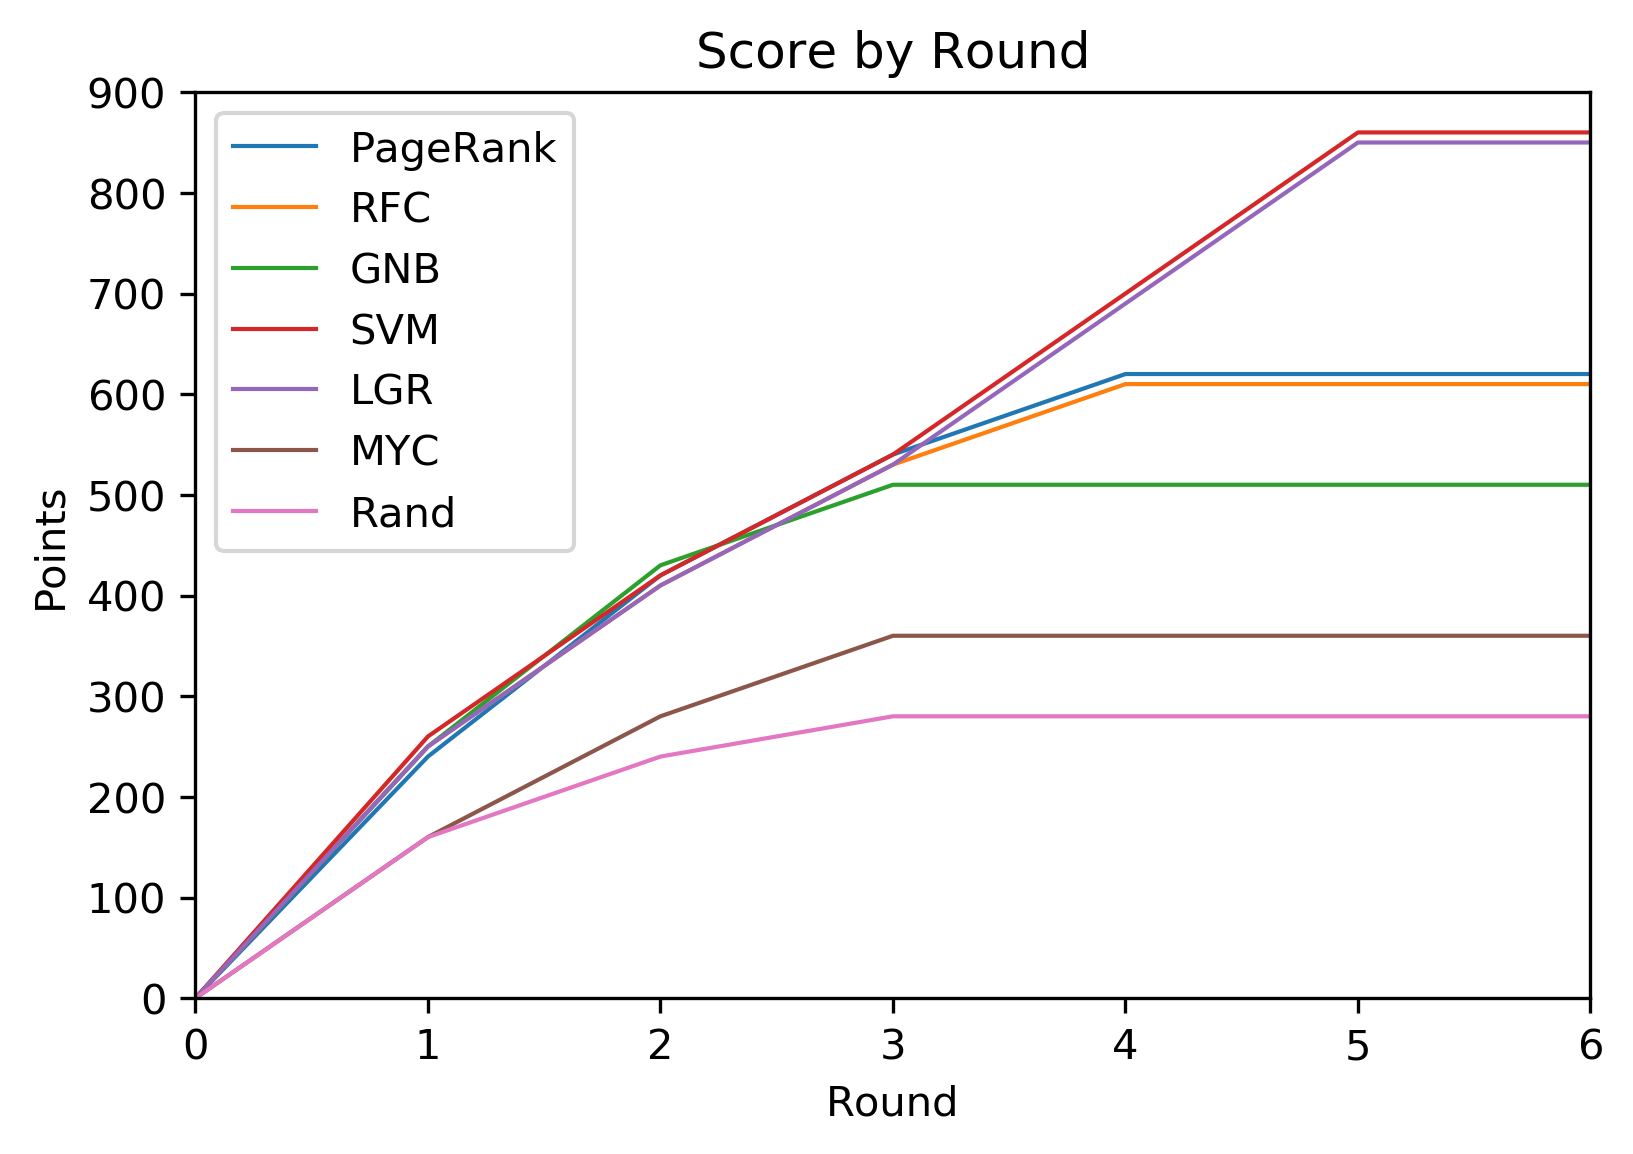

In [27]:
prn_prog = score_progression(full_tourney_pagerank)
gnb_prog = score_progression(full_tourney_gnb)
svc_prog = score_progression(full_tourney_svc)
lgr_prog = score_progression(full_tourney_lgr)
rfc_prog = score_progression(full_tourney_rfc)
myc_prog = score_progression(full_tourney_myc)
#rand_prog = score_progression(full_tourney_rand)
print(prn_prog)
print(gnb_prog)
print(svc_prog)
print(lgr_prog)
print(rfc_prog)
print(myc_prog)
print(rand_prog)
rounds = np.arange(0,7,1)
plt.plot(rounds,prn_prog,label='PageRank',linewidth=1.0)
plt.plot(rounds,rfc_prog,label='RFC',linewidth=1.0)
plt.plot(rounds,gnb_prog,label='GNB',linewidth=1.0)
plt.plot(rounds,svc_prog,label='SVM',linewidth=1.0)
plt.plot(rounds,lgr_prog,label='LGR',linewidth=1.0)
plt.plot(rounds,myc_prog,label='MYC',linewidth=1.0)
plt.plot(rounds,rand_prog,label='Rand',linewidth=1.0)
plt.title('Score by Round')
plt.xlabel('Round')
plt.ylabel('Points')
plt.axis([0,6,0,900])
plt.legend()
plt.savefig("Current_Scores.pdf",bbox_inches="tight")
plt.show()

In [28]:
def count_impossible_games(bracket) :
    '''
    Counts num of impossible to guess games from past failures.
    '''
    total = 0
    points = 0
    ps = [20,40,80,160,320]
    rn = [16,8,4,2,1]
    for i in range(5) :
        cur = 0
        teams = bracket[rn[i]]
        for team in teams :
            if team not in actual_results[rn[i]*2] :
                cur += 1
        total += cur
        points += ps[i]*cur
    return total,points

In [29]:
print(count_impossible_games(full_tourney_pagerank))
print(count_impossible_games(full_tourney_gnb))
print(count_impossible_games(full_tourney_svc))
print(count_impossible_games(full_tourney_lgr))
print(count_impossible_games(full_tourney_rfc))
print(count_impossible_games(full_tourney_myc))
print(count_impossible_games(full_tourney_rand))

(10, 960)
(12, 1080)
(9, 820)
(9, 820)
(11, 1000)
(18, 1200)
(24, 1420)


In [30]:
def count_ggc(bracket) :
    '''
    Counts the number of games correctly guessed
    '''
    total = 0
    for i in range(6) :
        total += np.sum([actual_results[2**i][j] == bracket[2**i][j] for j in range(len(bracket[2**i]))])
    return total

In [31]:
print(count_ggc(full_tourney_pagerank))
print(count_ggc(full_tourney_gnb))
print(count_ggc(full_tourney_svc))
print(count_ggc(full_tourney_lgr))
print(count_ggc(full_tourney_rfc))
print(count_ggc(full_tourney_myc))
print(count_ggc(full_tourney_rand))

37
36
40
39
37
24
19


In [32]:
methods = [full_tourney_pagerank,full_tourney_gnb,full_tourney_svc,full_tourney_lgr,full_tourney_rfc,full_tourney_myc,full_tourney_rand]
meth_names = ['PageRank','GNB','SVM','LGR','RFC','MYC','Random']
imp_stats = pd.DataFrame(index=meth_names,columns=['GGC','IGs'])
ips_stats = pd.DataFrame(index=meth_names,columns=['IPs'])
for i in range(len(methods)) :
    if i == len(methods)-1 :
        ips_stats.iloc[i,0] = 1360
        imp_stats.iloc[i,0] = 21
        imp_stats.iloc[i,1] = 21
    else :
        imp_games = count_impossible_games(methods[i])
        ips_stats.iloc[i,0] = imp_games[1]
        imp_stats.iloc[i,0] = count_ggc(methods[i])
        imp_stats.iloc[i,1] = imp_games[0]

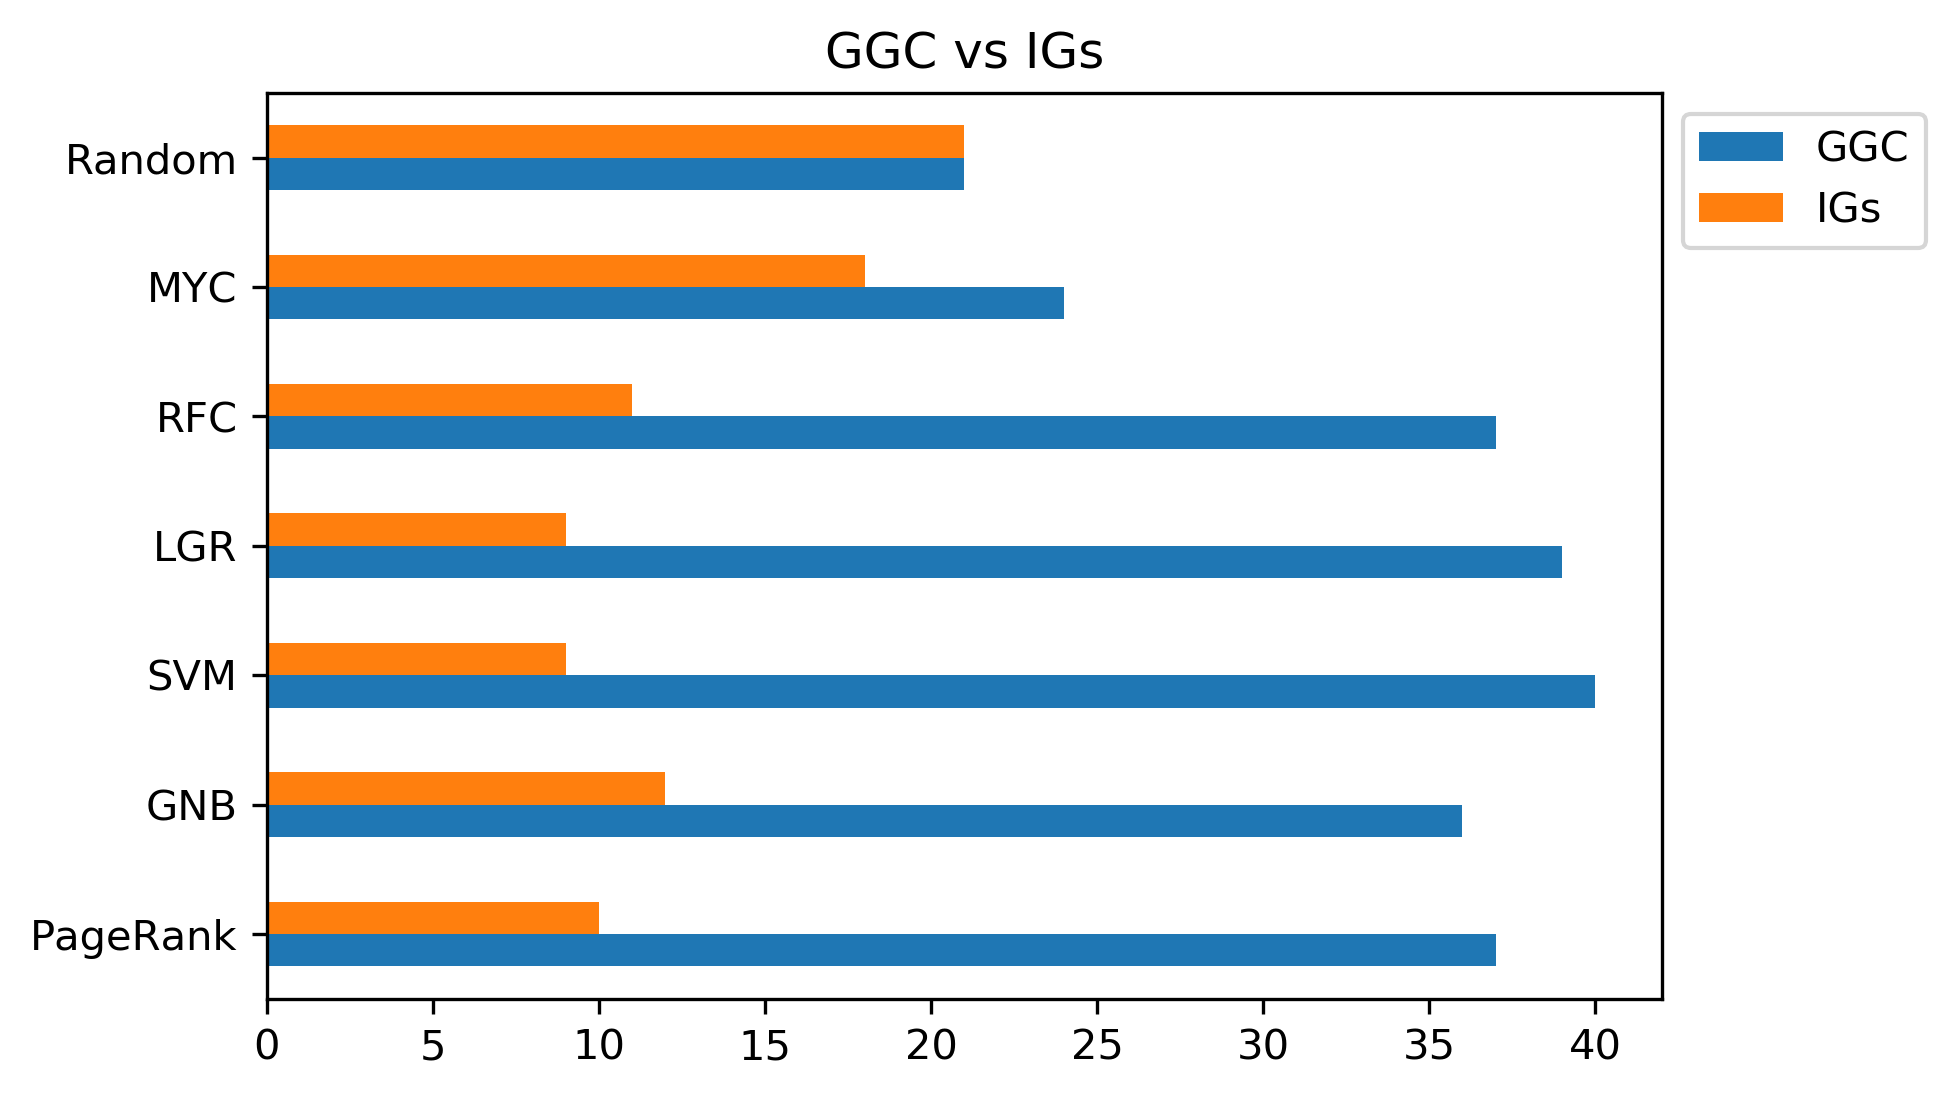

In [35]:
fig, ax1 = plt.subplots(1, 1)
imp_stats.plot(kind='barh',title='GGC vs IGs',ax=ax1,rot=0)
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.savefig("GGC_vs_IGs.pdf",bbox_inches='tight')
plt.show()

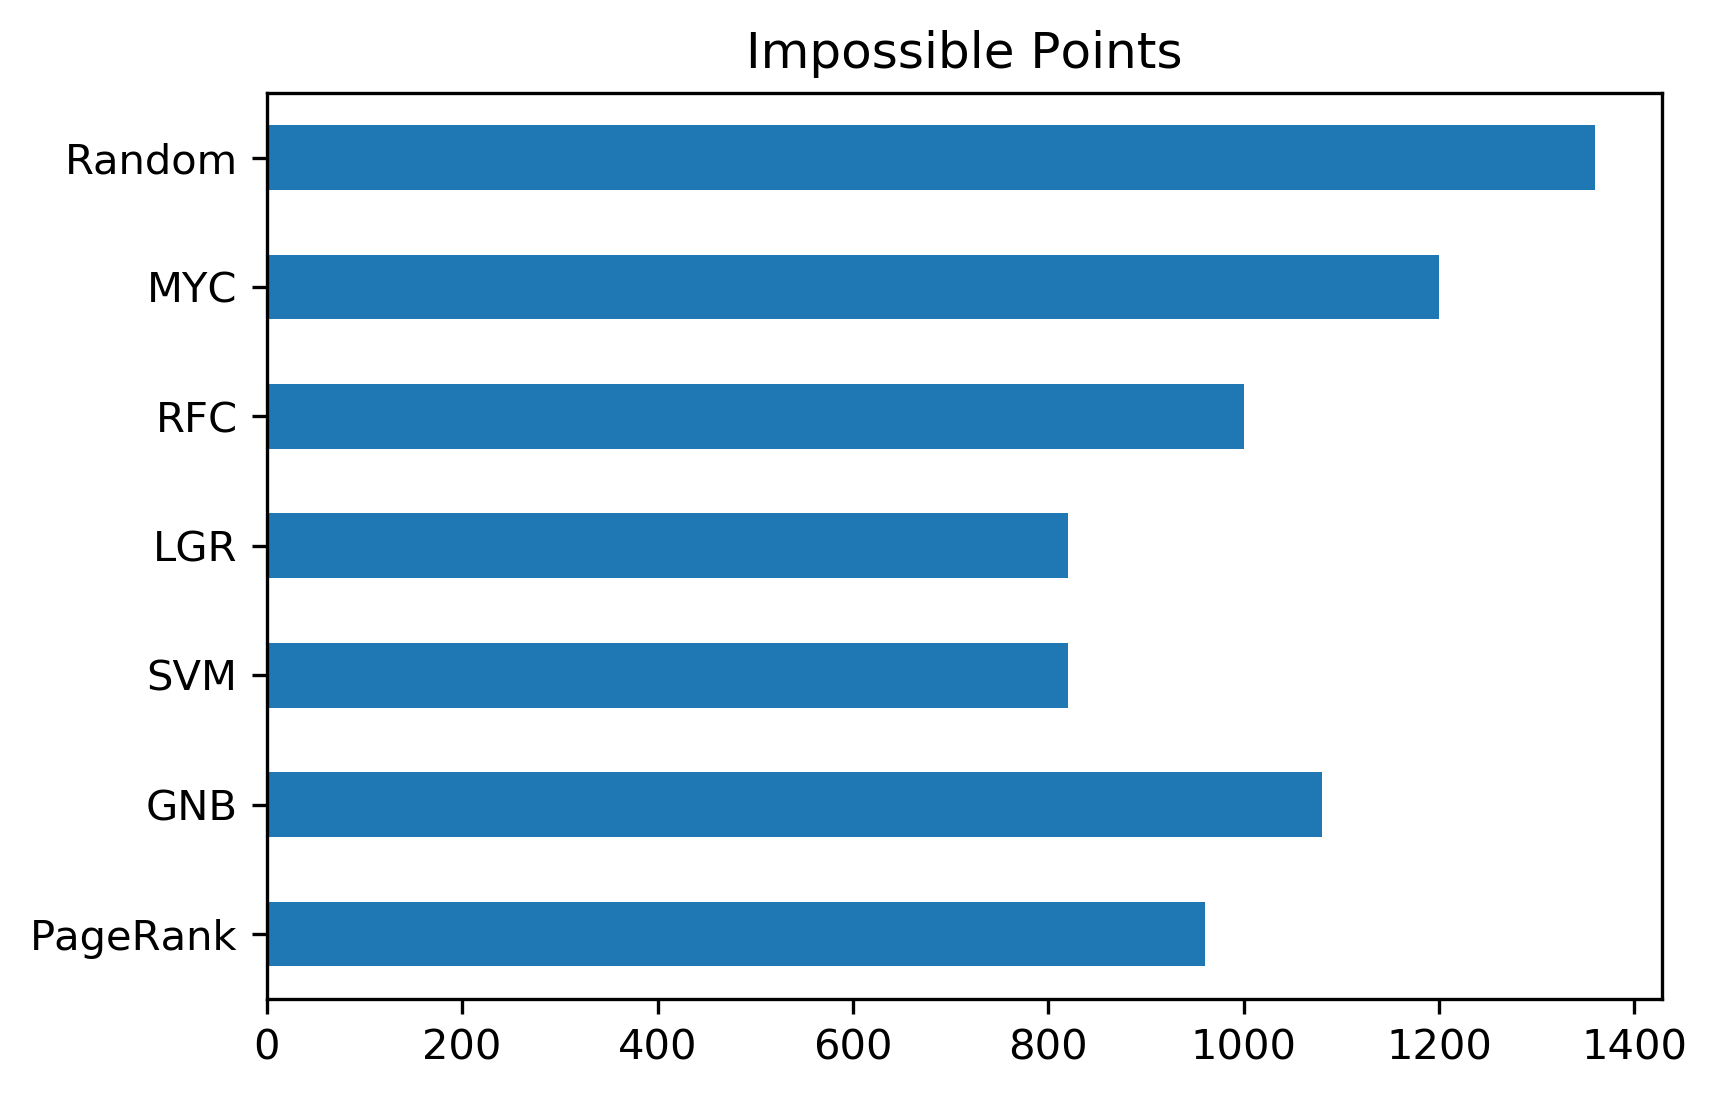

In [36]:
fig, ax1 = plt.subplots(1, 1)
ips_stats.plot(kind='barh',title='Impossible Points',ax=ax1,legend=None)
plt.savefig("Impossible_Points.pdf",bbox_inches="tight")
plt.show()